In [248]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb

### Preparing

In [180]:
df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [181]:
len(df)

891

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [183]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

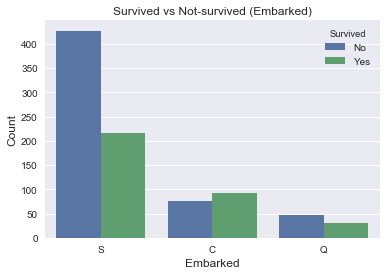

In [184]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "Embarked", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (Embarked)", fontsize = 12)
plt.xlabel("Embarked", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

In [185]:
#Fill Embarked with the mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

In [186]:
#Fill Age for null values
age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
df['Age'][np.isnan(df['Age'])] = age_null_random_list
df['Age'] = df['Age'].astype(int)

In [187]:
    #Adding new features
df['FamilySize'] = df ['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 1 #initialize to yes/1 is alone
df['IsAlone'].loc[df['FamilySize'] > 1] = 0

In [188]:
#Adding and Mapping Title
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

In [189]:
    # Mapping Fare
df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
df.loc[ df['Fare'] > 31, 'Fare'] = 3
df['Fare'] = df['Fare'].astype(int)
    
    # Mapping Age
df['age_act']=df['Age']
df.loc[ df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
df.loc[ df['Age'] > 64, 'Age'] = 4 ;

In [190]:
#if cabin is filled then fill it with 1
df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [191]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
df = df.drop(drop_elements, axis = 1)


In [192]:
    # Map sex
df['Sex'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping Embarked
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

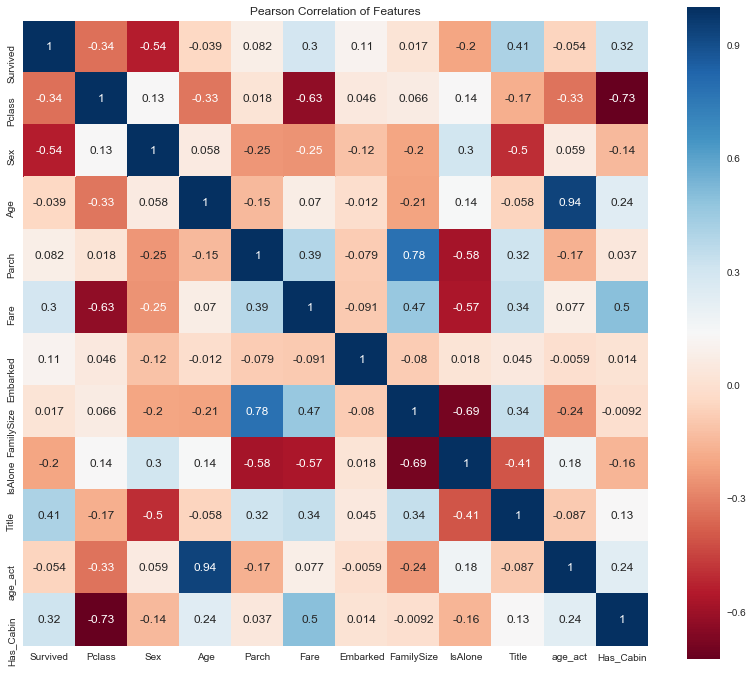

In [193]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(df.astype(float).corr(), 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [194]:
df.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,IsAlone,Title,age_act,Has_Cabin
0,0,3,1,1,0,0,0,2,0,1,22,0
1,1,1,0,2,0,3,1,2,0,3,38,1
2,1,3,0,1,0,1,0,1,1,2,26,0
3,1,1,0,2,0,3,0,2,0,3,35,1
4,0,3,1,2,0,1,0,1,1,1,35,0


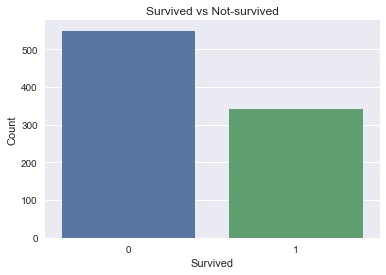

In [195]:
fig = plt.figure()
ax = sns.countplot(df.Survived)
ax.set(xlabel='Survived', ylabel='Count')
plt.title('Survived vs Not-survived')

plt.show()

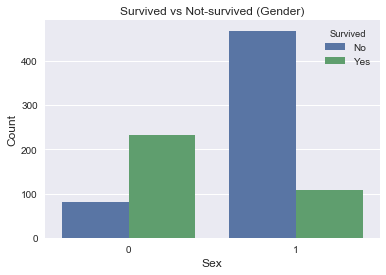

In [196]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "Sex", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (Gender)", fontsize = 12)
plt.xlabel("Sex", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

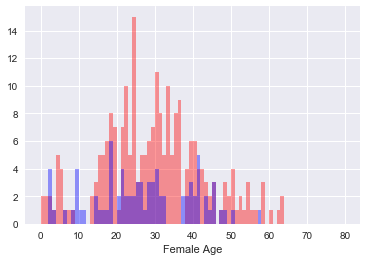

In [197]:
female_surv = df[(df['Survived']==1) & (df['Sex']==0)]
female_nosurv = df[(df['Survived']==0) & (df['Sex']==0)]

plt.figure()
plt.subplot()
sns.distplot(female_surv['age_act'].dropna().values, bins=range(0, 81, 1), color="red", kde=False)
sns.distplot(female_nosurv['age_act'].dropna().values, bins=range(0, 81, 1),  color="blue", kde=False,
            axlabel='Female Age')

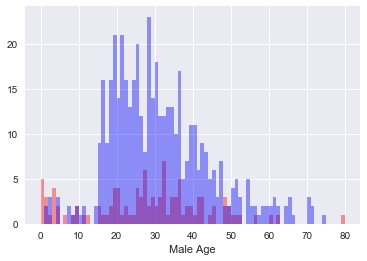

In [198]:
male_surv = df[(df['Survived']==1) & (df['Sex']==1)]
male_nosurv = df[(df['Survived']==0) & (df['Sex']==1)]

plt.figure()
plt.subplot()
sns.distplot(male_surv['age_act'].values, bins=range(0, 81, 1),color="red", kde=False)
sns.distplot(male_nosurv['age_act'].values, bins=range(0, 81, 1), color="blue",kde=False,
            axlabel='Male Age')

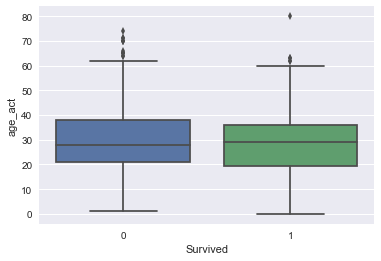

In [199]:
sns.boxplot(x="Survived", y="age_act", data=df, )

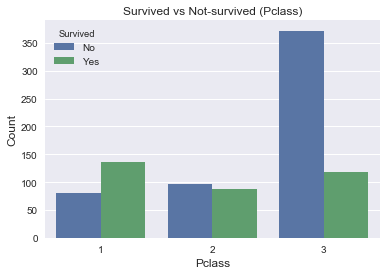

In [200]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "Pclass", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (Pclass)", fontsize = 12)
plt.xlabel("Pclass", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

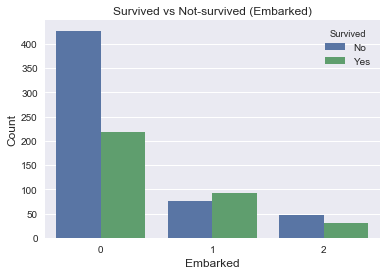

In [201]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "Embarked", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (Embarked)", fontsize = 12)
plt.xlabel("Embarked", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

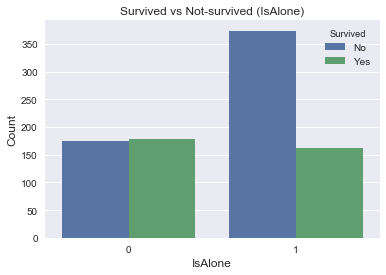

In [202]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "IsAlone", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (IsAlone)", fontsize = 12)
plt.xlabel("IsAlone", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

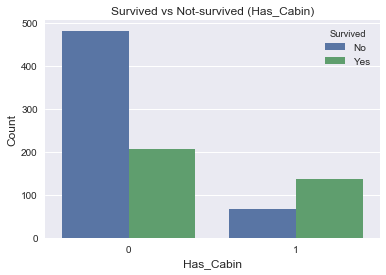

In [203]:
sns.set()
plt.subplots()
ax = sns.countplot(x = "Has_Cabin", 
                   hue="Survived",
                   data = df, 
                   linewidth=1)

## Fixing title, xlabel and ylabel
plt.title("Survived vs Not-survived (Has_Cabin)", fontsize = 12)
plt.xlabel("Has_Cabin", fontsize = 12);
plt.ylabel("Count", fontsize = 12)
## Fixing legends
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

In [210]:
df.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,IsAlone,Title,age_act,Has_Cabin
0,0,3,1,1,0,0,0,2,0,1,22,0
1,1,1,0,2,0,3,1,2,0,3,38,1
2,1,3,0,1,0,1,0,1,1,2,26,0
3,1,1,0,2,0,3,0,2,0,3,35,1
4,0,3,1,2,0,1,0,1,1,1,35,0


### Modeling

In [218]:
cols = ['Pclass','Sex','Age', 'Parch','Embarked','FamilySize','IsAlone','Has_Cabin']

tcols = np.append(['Survived'],cols)
train, test = train_test_split(df, test_size=0.2)

X = train.loc[:,cols]
y = np.ravel(train.loc[:,['Survived']])

X_test = test.loc[:,cols]
y_test = np.ravel(test.loc[:,['Survived']])

In [225]:
#Logistic Regression
from sklearn.model_selection import cross_val_score
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log)


0.808929129007


In [226]:
#Perceptron
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)


0.672839177604


In [227]:
#K Nearest Neighbours
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)


0.786492271089


In [228]:
#SVM
clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)


0.813174179731


In [230]:
#Naive Bayes
clf_bay = GaussianNB()
clf_bay.fit(X,y)
score_bay = cross_val_score(clf_bay, X, y, cv=5).mean()
print(score_bay)


0.793465160352


In [231]:
#Bagging 
bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)


0.808988764045


In [232]:
#Decision Tree
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)



0.797730608219


In [233]:
#Random Forest
clf_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)


0.827239546988


In [234]:
#eXtreme Gradient Boosting - XGBoost:
clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_xgb.fit(X,y)
score_xgb = cross_val_score(clf_xgb, X, y, cv=5).mean()
print(score_xgb)


0.827219848377


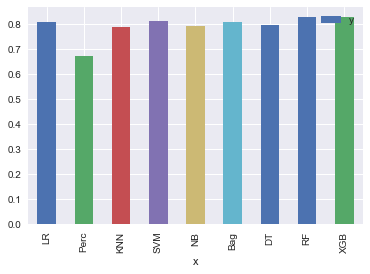

In [246]:
x=['LR','Perc', 'KNN','SVM','NB', 'Bag', 'DT', 'RF', 'XGB']
y=[0.808,0.672,0.786,0.813,0.79,0.808,0.797,0.827,0.827]
ff=pd.DataFrame({'x':x,'y':y})

ax = ff.plot.bar(x='x', y='y')
